**Open Set Classification with MNIST**

by Liz Gokhvat and Noa Levy 

**Imports**

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Dataset, DataLoader, Subset, random_split, ConcatDataset
from tqdm.auto import tqdm
from torchvision.datasets import MNIST, CIFAR10,FashionMNIST
import time
from collections import defaultdict
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle

**Project utils**

In [2]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10



def eval_model(model, data_loader, device):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            ### Modify output if needed ###
            # CHANGE: removed flattening of the image
            # data = data.view(-1, 28*28)

            # CHANGE:used model predict function instead of the forward function
            outputs = model.predict(data)


            # y pred should be a vector of size (N_batch,) -> [5, 2, ..., 10]
            # and not one-hot. You can handle this either in your model or here.

            outputs = outputs.to(device)

            # Assuming the model returns an (N_batch, 11) size output
            probas, y_pred = torch.max(outputs, 1)

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot!
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total

**Eval Mode**

In [3]:
eval_mode = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Prepare data**

In [4]:
# MNIST dataset
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

aug_transform = transforms.Compose([transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,)),
                      transforms.RandomAffine(degrees=(-20, 20), translate=(0.01, 0.15),
                                     scale=(0.9, 1.1),fill=-1)])

train_batch_size = 512
test_batch_size = 2048

trainset_MNIST = MNIST(root='./data', train=True, download=True, transform=transform_MNIST)

trainset_aug = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=aug_transform)
# Sample 20% of the training dataset
total_train_samples = len(trainset_MNIST)
sample_size = int(0.2 * total_train_samples)

# For reproducibility
np.random.seed(42)
indices = np.random.permutation(total_train_samples)[:sample_size]

sampled_trainset = Subset(trainset_MNIST, indices)
sampled_trainset_aug = Subset(trainset_aug, indices)

# Split the sampled dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * sample_size)

indices2=np.random.permutation(sample_size)[:train_size]
train_subset_MNIST = Subset(sampled_trainset, indices2)
train_subset_MNIST_aug = Subset(sampled_trainset_aug, indices2)

aug_size=int(0.25*train_size)
indices_aug=np.random.permutation(train_size)[:aug_size]
train_subset_MNIST_aug = Subset(train_subset_MNIST_aug, indices_aug)

val_subset_MNIST = [sampled_trainset[i] for i in range(sample_size) if i not in indices2]

combined_trainset_MNIST = ConcatDataset([train_subset_MNIST, train_subset_MNIST_aug])

# Create dataloaders for the training and validation sets
combined_train_loader_MNIST = DataLoader(
    combined_trainset_MNIST, batch_size=train_batch_size, shuffle=True, num_workers=2)

train_loader_MNIST = DataLoader(
    train_subset_MNIST, batch_size=train_batch_size, shuffle=True, num_workers=2)

val_loader_MNIST = DataLoader(
    val_subset_MNIST, batch_size=train_batch_size, shuffle=False, num_workers=2)

testset_MNIST = MNIST(root='./data', train=False, download=True, transform=transform_MNIST)

# Create a dataloader for the test set
test_loader_MNIST = DataLoader(
    testset_MNIST, batch_size=test_batch_size, shuffle=False, num_workers=2)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.37MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# CIFAR10 dataset
sample_size_CIFAR10=2000
transform_CIFAR10 = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(28),
                                    transforms.Grayscale(num_output_channels=1),
                                     transforms.Normalize(0.5, 0.5)
                                     ])

testset_CIFAR10 = CIFAR10(root="./data", train=False, transform=transform_CIFAR10, download=True)

indices = np.random.permutation(len(testset_CIFAR10))[:sample_size_CIFAR10]

test_subset_CIFAR10 = Subset(testset_CIFAR10, indices)

100%|██████████| 170M/170M [00:03<00:00, 48.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
# FashionMNIST dataset
sample_size_FashionMNIST=2000
transform_FashionMNIST = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(28),
                                     transforms.Normalize(0.5, 0.5)
                                     ])

testset_FashionMNIST = FashionMNIST(root="./data", train=False, transform=transform_FashionMNIST, download=True)

indices = np.random.permutation(len(testset_FashionMNIST))[:sample_size_FashionMNIST]

test_subset_FashionMNIST = Subset(testset_FashionMNIST, indices)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.85MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.8MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



**Model Architecture**

*Baseline Model*

In [7]:
class Baseline_Model(nn.Module):
    def __init__(self):
        super(Baseline_Model, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

*OSR Model*

In [8]:
class OSR_Model(nn.Module):
    def __init__(self):
        super(OSR_Model, self).__init__()
        self.avg_embeddings = {}

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.size = 512*3*3
        self.fc1 = nn.Linear(self.size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def calc_avg_embeddings_per_label(self, loader):
      self.eval()
      all_embeddings, all_labels = [], []

      # Collect embeddings and labels
      for data, label in loader:
          data, label = data.to(device), label.to(device)
          with torch.no_grad():
              _, embedding = self(data)  # Get the embedding vector for the data point
              all_embeddings.append(embedding)
              all_labels.append(label)

      all_embeddings = torch.cat(all_embeddings, dim=0)
      all_labels = torch.cat(all_labels, dim=0)

      avg_embeddings = {}
      unique_labels = torch.unique(all_labels)

      # Calculate average embeddings and threshold distances
      for lbl in unique_labels:
          label_embeddings = all_embeddings[all_labels == lbl]
          avg_embedding = torch.mean(label_embeddings, dim=0)
          distances = torch.norm(label_embeddings - avg_embedding, dim=1)

          threshold_distance = torch.mean(distances) * 0.5 + torch.max(distances) * 0.5
          avg_embeddings[lbl.item()] = {'avg_embedding': avg_embedding, 'threshold_distance': threshold_distance}

      self.avg_embeddings = avg_embeddings
      return avg_embeddings


    def forward(self, x):
        x = self.relu(F.max_pool2d(self.conv1(x),2))
        x = self.relu(self.conv2(x))
        x = self.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.relu(self.conv4(x))
        x = self.relu(F.max_pool2d(self.conv5(x), 2))
        x = self.relu(self.conv6(x))
        x = x.view(-1, self.size)
        x=self.relu(self.fc1(x))
        x=self.relu(self.fc2(x))
        x = self.fc3(x)
        embedding=x
        x=self.relu(x)
        x=self.relu(self.fc4(x))
        x = self.fc5(x)
        return self.softmax(x), embedding

    def predict(self, x):
      self.eval()
      pred, emb = self.forward(x)
      new_pred = torch.zeros(pred.size(0), 11).to(x.device)
      new_pred[:, :10] = pred

      for i in range(pred.size(0)):
          label = torch.argmax(pred[i]).item()
          distance = torch.norm(emb[i] - self.avg_embeddings[label]['avg_embedding'])

          if distance > self.avg_embeddings[label]['threshold_distance']:
              label = 10  # Mark as outlier

          new_pred[i, label] = 1

      return self.softmax(new_pred)



**Training Functions**

In [9]:
def train_baseline_model(model, optimizer, train_loader, val_loader, num_epochs, criterion, device=None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)

    results_dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    since = time.time()

    for epoch in tqdm(range(num_epochs), desc="Training model"):

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass and track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            results_dict[f'{phase}_loss'].append(epoch_loss)
            results_dict[f'{phase}_acc'].append(epoch_acc.item())


    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return results_dict

In [10]:
def create_triplets(img, labels, embeddings, device):
    """
    Generate triplet batches (anchor, positive, negative) based on labels.
    """
    anchors, positives, negatives = [], [], []
    unique_labels = labels.unique()

    for label in unique_labels:
        label_mask = labels == label
        non_label_mask = ~label_mask

        # Embeddings for the current class (positives)
        positive_embeddings = embeddings[label_mask]

        # Embeddings for other classes (negatives)
        negative_embeddings = embeddings[non_label_mask]

        for anchor in positive_embeddings:
            positives.append(positive_embeddings[torch.randint(0, len(positive_embeddings), (1,))])
            negatives.append(negative_embeddings[torch.randint(0, len(negative_embeddings), (1,))])
            anchors.append(anchor)

    # Convert to tensors
    anchors = torch.stack(anchors).to(device)
    positives = torch.stack(positives).squeeze().to(device)
    negatives = torch.stack(negatives).squeeze().to(device)

    return anchors, positives, negatives

In [11]:
def train_model_osr(model, train_loader, val_loader, learning_rate=0.1, margin=1.0, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    clf_criterion = nn.NLLLoss()
    triplet_loss_fn = nn.TripletMarginLoss(margin=margin)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    results_dict = {
        'train_loss_clf': [],
        'train_loss_triplet': [],
        'val_loss_clf': [],
        'val_loss_triplet': [],
        'train_acc': [],
        'val_acc': []
    }

    since = time.time()

    for epoch in tqdm(range(num_epochs), desc="Training model"):
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()
              dataloader = train_loader
          else:
              model.eval()
              dataloader = val_loader

          loss_clf_epoch = 0
          loss_triplet_epoch = 0
          running_corrects = 0
          total_samples = 0

          for data in dataloader:
              # Batch loss for updating the model
              loss = 0
              optimizer.zero_grad()
              img, labels = data
              img = img.to(device)
              labels = labels.to(device)

              # Forward pass and track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                preds, embeddings = model(img)

                loss_clf_batch = clf_criterion(preds, labels)
                loss += loss_clf_batch
                loss_clf_epoch += loss_clf_batch.item()

                _, preds = torch.max(preds, 1)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

                # Generate triplets based on labels
                anchors, positives, negatives = create_triplets(img, labels, embeddings, device)
                loss_triplet_batch = triplet_loss_fn(anchors, positives, negatives)
                loss += loss_triplet_batch
                loss_triplet_epoch += loss_triplet_batch.item()


                if phase == 'train':
                  # Backward pass and optimization
                  loss.backward()
                  optimizer.step()

          # Record losses
          results_dict[f'{phase}_loss_clf'].append(loss_clf_epoch / len(dataloader))
          results_dict[f'{phase}_loss_triplet'].append(loss_triplet_epoch / len(dataloader))
          results_dict[f'{phase}_acc'].append((running_corrects.double() / total_samples).cpu().item())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, results_dict


**Create and Train Model**

*Baseline Model*

In [12]:
baseline_model=Baseline_Model()
if not eval_mode:
  baseline_model.to(device)
  num_epochs = 50
  optimizer = optim.Adam(baseline_model.parameters(), lr=0.002,weight_decay=1e-5)
  criterion = nn.NLLLoss()
  results_dict=train_baseline_model(baseline_model, optimizer, train_loader_MNIST, val_loader_MNIST, num_epochs, criterion, device)

  # save model weights
  torch.save(baseline_model.state_dict(), 'baseline_model.pth')

*OSR Model*

In [13]:
model_osr=OSR_Model()
if not eval_mode:
  model_osr.to(device)
  num_epochs = 60
  clf_criterion = nn.NLLLoss()
  model_osr, results_dict_osr = train_model_osr(model_osr,combined_train_loader_MNIST, val_loader_MNIST, learning_rate=0.0003 ,margin=1.0,num_epochs=num_epochs)
  avg_embeddings = model_osr.calc_avg_embeddings_per_label(train_loader_MNIST)

  model_info = {
      'model_state_dict': model_osr.state_dict(),
      'avg_embeddings': model_osr.avg_embeddings
  }

  # Save the model
  torch.save(model_info, 'model_osr.pth')

**Evaluation**

*Load Model Weights*

Baseline

In [14]:
if eval_mode:
  baseline_model_path = 'baseline_model.pth'
  baseline_model.load_state_dict(torch.load(baseline_model_path, map_location=device))
  baseline_model.to(device)
  baseline_model.eval()

<ipython-input-14-93da4ba47ff3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_model.load_state_dict(torch.load(baseline_model_path, map_location=device))


OSR

In [15]:
if eval_mode:
  model_info = torch.load('model_osr.pth')

  model_osr.load_state_dict(model_info['model_state_dict'])
  model_osr.avg_embeddings = model_info['avg_embeddings']

  model_osr.to(device)
  for i in range(10):
        model_osr.avg_embeddings[i]['avg_embedding'] = model_osr.avg_embeddings[i]['avg_embedding'].to(device)
        model_osr.avg_embeddings[i]['threshold_distance'] = model_osr.avg_embeddings[i]['threshold_distance'].to(device)

  model_osr.eval()

<ipython-input-15-745f9c385254>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_info = torch.load('model_osr.pth')


*Plot Functions*

In [16]:
def get_labels(model, data_loader, model_type=""):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            if model_type == "baseline":
                outputs = model(images)
            elif model_type == "osr":
                outputs = model.predict(images)
            else:
                print("Invalid model type")

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

In [17]:
def plot_confusion_matrix(confusion_matrix, class_names,title):
    plt.figure(figsize=(6,5))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted",fontsize=14)
    plt.ylabel("True",fontsize=14)
    plt.title(title,fontsize=16)
    plt.tight_layout()
    if not eval_mode:
      plt.savefig(title+'.png')
    plt.show()

*Baseline Results*

In [18]:
def evalMNIST(model, loader):
  correct_count, all_count = 0, 0
  for images,labels in loader:
    for i in range(len(labels)):
      img = images[i].view(1, 784).to(device)
      with torch.no_grad():
          logps = model(img)

      ps = torch.exp(logps).detach().cpu().numpy()
      probab = list(ps[0])
      pred_label = probab.index(max(probab))
      true_label = labels.numpy()[i]
      if(true_label == pred_label):
        correct_count += 1
      all_count += 1

  return (correct_count/all_count)

In [19]:
test_accuracy = evalMNIST(baseline_model, test_loader_MNIST)
print("Baseline Model Test Accuracy: ", test_accuracy)
train_accuracy = evalMNIST(baseline_model, train_loader_MNIST)
print("Baseline Model Train Accuracy: ", train_accuracy)

Baseline Model Test Accuracy:  0.9518
Baseline Model Train Accuracy:  0.9982291666666666


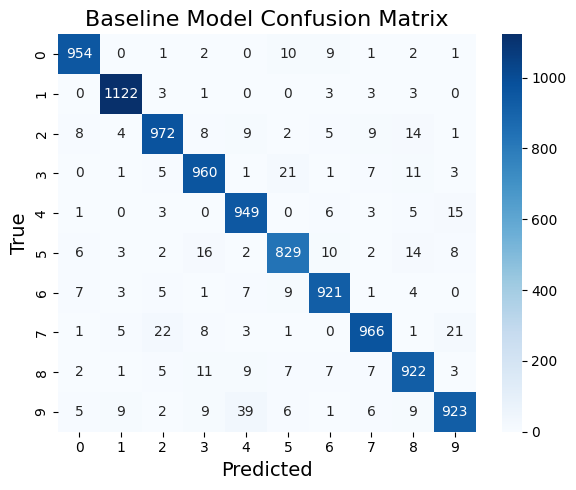

In [20]:
pred_labels, true_labels = get_labels(baseline_model, test_loader_MNIST,"baseline")
confusion_matrix_MNIST = confusion_matrix(true_labels, pred_labels)
class_names_MNIST = [str(i) for i in range(10)]
plot_confusion_matrix(confusion_matrix_MNIST, class_names_MNIST,'Baseline Model Confusion Matrix')

Our open set recognition (OSR) approach uses a multi-task learning setup that combines standard classification loss with triplet loss. We compute class-specific centroids from the training data, and assign each new sample to “unknown” if its embedding lies outside a predefined distance threshold from the appropriate centroid.

*Prepare combined datasets*

In [21]:
# create combined datasets for cifar and fashion
batch_size = 1024
combined_set_FashionMNIST=CombinedDataset(testset_MNIST,test_subset_FashionMNIST)
combined_loader_FashionMNIST = DataLoader(combined_set_FashionMNIST, batch_size=batch_size, shuffle=True)
combined_set_CIFAR10 =CombinedDataset(testset_MNIST,test_subset_CIFAR10)
combined_loader_CIFAR10 = DataLoader(combined_set_CIFAR10, batch_size=batch_size, shuffle=True)

In [22]:
acc_mnist_fashion, acc_ood_fashion, acc_total_fashion = eval_model(model_osr, combined_loader_FashionMNIST, device)
acc_mnist_cifar, acc_ood_cifar, acc_total_cifar = eval_model(model_osr, combined_loader_CIFAR10, device)

*OOD Results*

In [23]:
print(f'FashionMNIST OOD Accuracy: {acc_ood_fashion*100:.2f}%')

FashionMNIST OOD Accuracy: 97.80%


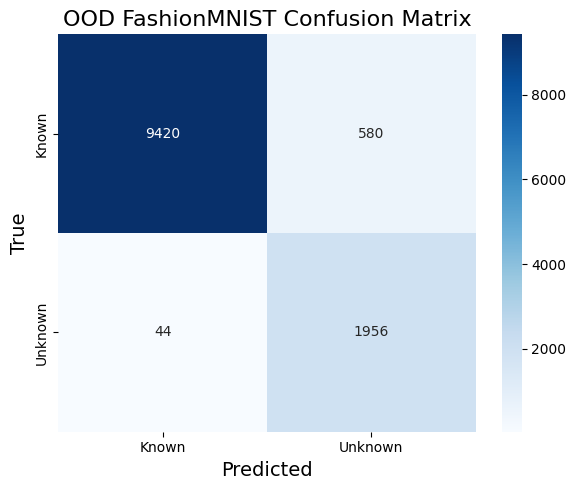

In [24]:
# Modify pred_labels
pred_labels, true_labels = get_labels(model_osr, combined_loader_FashionMNIST,"osr")
binary_pred_labels = [0 if label < 10 else 1 for label in pred_labels]

# Modify true_labels
binary_true_labels = [0 if label < 10 else 1 for label in true_labels]

binary_confusion_matrix_OSR = confusion_matrix(binary_true_labels, binary_pred_labels)
plot_confusion_matrix(binary_confusion_matrix_OSR, ['Known','Unknown'],'OOD FashionMNIST Confusion Matrix')

In [25]:
print(f'CIFAR10 OOD Accuracy: {acc_ood_cifar*100:.2f}%')

CIFAR10 OOD Accuracy: 100.00%


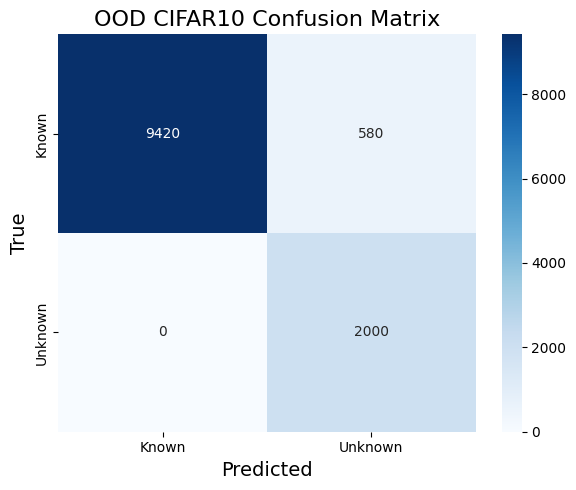

In [26]:
# Modify pred_labels
pred_labels, true_labels = get_labels(model_osr, combined_loader_CIFAR10,"osr")
binary_pred_labels = [0 if label < 10 else 1 for label in pred_labels]

# Modify true_labels
binary_true_labels = [0 if label < 10 else 1 for label in true_labels]

binary_confusion_matrix_OSR = confusion_matrix(binary_true_labels, binary_pred_labels)
plot_confusion_matrix(binary_confusion_matrix_OSR, ['Known','Unknown'],'OOD CIFAR10 Confusion Matrix')

*OSR Results*

In [27]:
print('FashionMNIST')
print(f'MNIST Accuracy: {acc_mnist_fashion*100:.2f}%')
print(f'Total Accuracy: {acc_total_fashion*100:.2f}%')

FashionMNIST
MNIST Accuracy: 94.03%
Total Accuracy: 94.66%


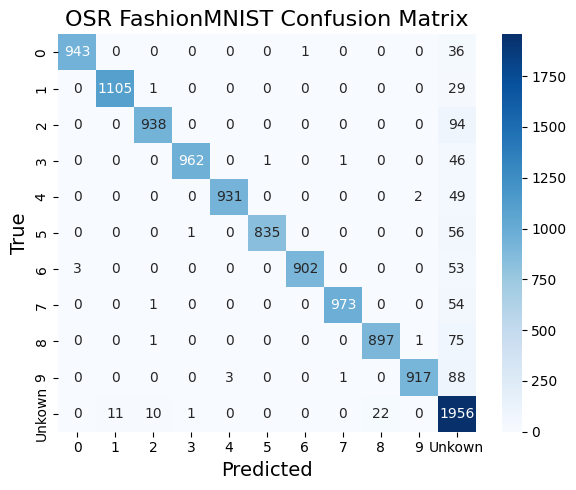

In [28]:
pred_labels, true_labels = get_labels(model_osr, combined_loader_FashionMNIST,"osr")
confusion_matrix_OSR = confusion_matrix(true_labels, pred_labels)
class_names_OSR = [str(i) for i in range(11)]
class_names_OSR[10] = 'Unkown'
plot_confusion_matrix(confusion_matrix_OSR, class_names_OSR,'OSR FashionMNIST Confusion Matrix')

In [29]:
print('CIFAR10')
print(f'MNIST Accuracy: {acc_mnist_cifar*100:.2f}%')
print(f'Total Accuracy: {acc_total_cifar*100:.2f}%')

CIFAR10
MNIST Accuracy: 94.03%
Total Accuracy: 95.03%


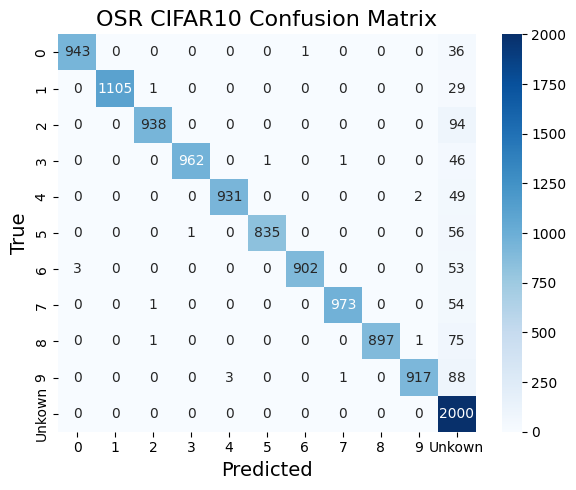

In [30]:
pred_labels, true_labels = get_labels(model_osr, combined_loader_CIFAR10,"osr")
confusion_matrix_OSR = confusion_matrix(true_labels, pred_labels)
class_names_OSR = [str(i) for i in range(11)]
class_names_OSR[10] = 'Unkown'
plot_confusion_matrix(confusion_matrix_OSR, class_names_OSR,'OSR CIFAR10 Confusion Matrix')

**Additional Figures**

In [31]:
def plot_training_results(val_results,train_results,title='',y_label='',x_label='Epoch'):
  epochs = range(1, len(train_results) + 1)
  plt.plot(epochs, train_results, label='Training')
  plt.plot(epochs, val_results, label='Validation')
  plt.xlabel(x_label, fontsize=14)
  plt.ylabel(y_label,fontsize=14)
  plt.title(title, fontsize=16)
  plt.legend(fontsize=14)
  plt.grid()
  plt.tight_layout()
  if not eval_mode:
    plt.savefig(title+'.png')
  plt.show()

In [32]:
if not eval_mode:
  plot_training_results(results_dict['val_loss'],results_dict['train_loss'],'Baseline Model Training vs. Validation Loss','Loss','Epoch')
  plot_training_results(results_dict['val_acc'],results_dict['train_acc'],'Baseline Model Training vs. Validation Accuracy','Accuracy','Epoch')

*OSR*

In [33]:
if not eval_mode:
  plot_training_results(results_dict_osr['val_loss_clf'],results_dict_osr['train_loss_clf'],'OSR Training vs. Validation Classification Loss','Classification Loss','Epoch')
  plot_training_results(results_dict_osr['val_loss_triplet'],results_dict_osr['train_loss_triplet'],'OSR Training vs. Validation Triplet Loss','Triplet Loss','Epoch')
  plot_training_results(results_dict_osr['val_acc'],results_dict_osr['train_acc'],'OSR Training vs. Validation Accuracy','Accuracy','Epoch')

In [34]:
def plot_mnist_embedding_distribution(model, dataloader, reduction_method='tsne', title="", num_samples=None):
    model.eval()
    device = next(model.parameters()).device

    embeddings_list = []
    labels_list = []

    # Gather embeddings and labels
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)

            _, embeddings = model(imgs)
            embeddings_list.append(embeddings.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    embeddings_all = np.concatenate(embeddings_list, axis=0)
    labels_all = np.concatenate(labels_list, axis=0)

    if num_samples is not None and num_samples < embeddings_all.shape[0]:
        indices = np.random.choice(embeddings_all.shape[0], num_samples, replace=False)
        embeddings_all = embeddings_all[indices]
        labels_all = labels_all[indices]

    # Reduce dimensionality to 2D for plotting
    if reduction_method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif reduction_method.lower() == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("reduction_method must be either 'tsne' or 'pca'")

    embeddings_2d = reducer.fit_transform(embeddings_all)

    plt.figure(figsize=(10, 8))

    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=labels_all, cmap= plt.get_cmap('tab20', 11), alpha=0.7, s=10)
    plt.colorbar(scatter, ticks=range(11))
    plt.title(f'{title} ({reduction_method.upper()})',fontsize=16)
    plt.xlabel('Component 1',fontsize=14)
    plt.ylabel('Component 2',fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    if not eval_mode:
      plt.savefig(f'{title} ({reduction_method.upper()}).png')
    plt.show()

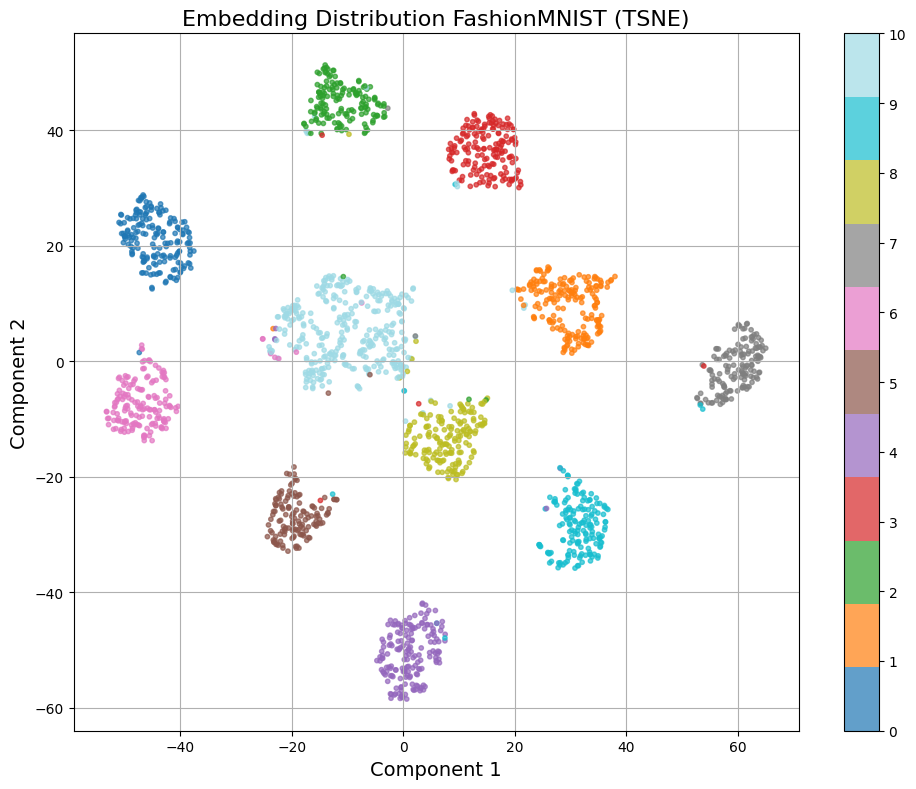

In [35]:
plot_mnist_embedding_distribution(model_osr, combined_loader_FashionMNIST, reduction_method='tsne', title="Embedding Distribution FashionMNIST",num_samples=2000)

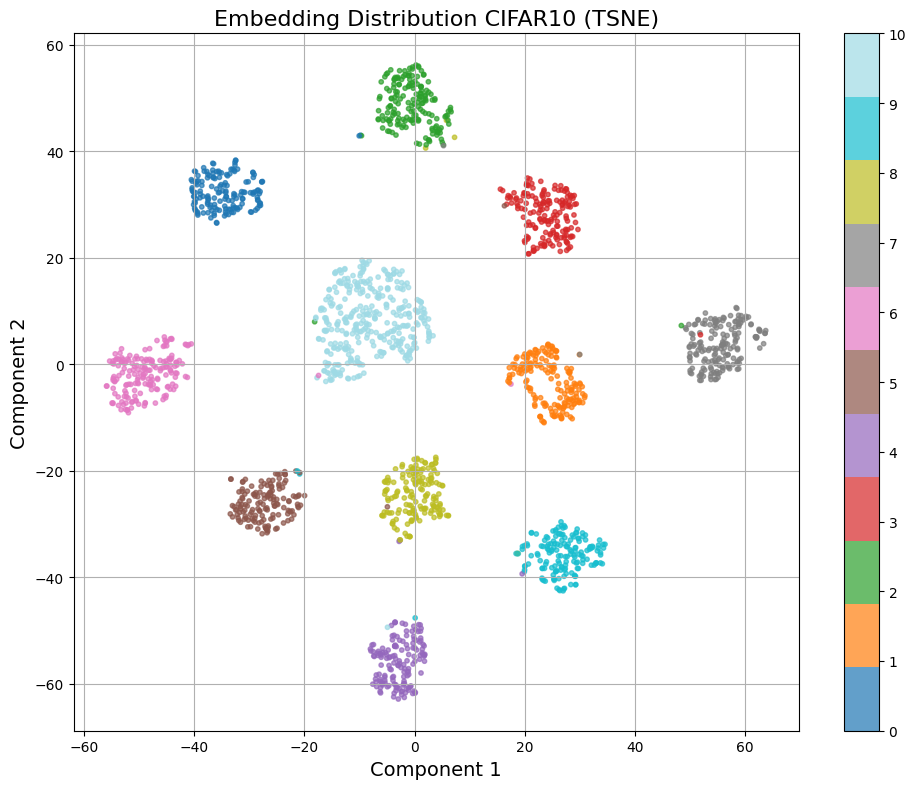

In [36]:
plot_mnist_embedding_distribution(model_osr, combined_loader_CIFAR10, reduction_method='tsne', title="Embedding Distribution CIFAR10",num_samples=2000)

**Evaluation For Unknown Dataset**

In [37]:
osr_dataset = test_subset_CIFAR10 # placeholder
combined_dataset = CombinedDataset(testset_MNIST,osr_dataset)
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
acc_mnist, acc_ood, acc_total = eval_model(model_osr, combined_loader_CIFAR10, device)

*OOD*

In [38]:
print(f'Unknown OOD Accuracy: {acc_ood_cifar*100:.2f}%')

Unknown OOD Accuracy: 100.00%


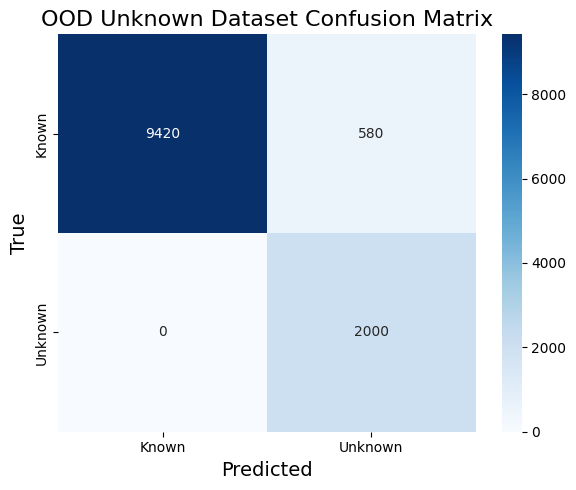

In [39]:
# Modify pred_labels
pred_labels, true_labels = get_labels(model_osr, combined_loader,"osr")
binary_pred_labels = [0 if label < 10 else 1 for label in pred_labels]

# Modify true_labels
binary_true_labels = [0 if label < 10 else 1 for label in true_labels]

binary_confusion_matrix_OSR = confusion_matrix(binary_true_labels, binary_pred_labels)
plot_confusion_matrix(binary_confusion_matrix_OSR, ['Known','Unknown'],'OOD Unknown Dataset Confusion Matrix')

*OSR*

In [40]:
print('Unknown Dataset')
print(f'MNIST Accuracy: {acc_mnist_cifar*100:.2f}%')
print(f'Total Accuracy: {acc_total_cifar*100:.2f}%')

Unknown Dataset
MNIST Accuracy: 94.03%
Total Accuracy: 95.03%


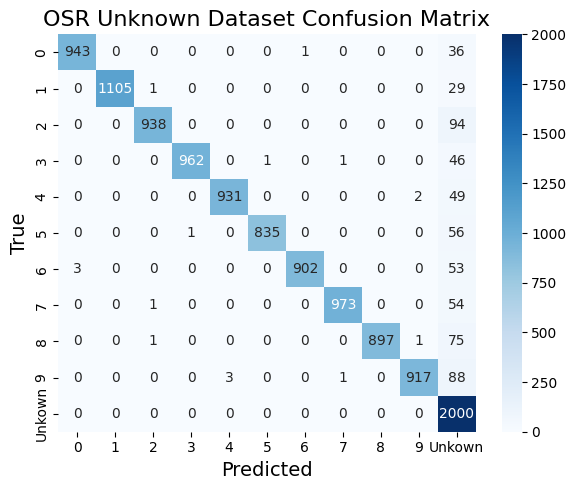

In [41]:
pred_labels, true_labels = get_labels(model_osr, combined_loader,"osr")
confusion_matrix_OSR = confusion_matrix(true_labels, pred_labels)
class_names_OSR = [str(i) for i in range(11)]
class_names_OSR[10] = 'Unkown'
plot_confusion_matrix(confusion_matrix_OSR, class_names_OSR,'OSR Unknown Dataset Confusion Matrix')